# T-tests : Investigate the effect of world events on the music listening

With the t-test, we assume that the data N days before and N days after the event are two seperate groups. We would like to investigate if these groups differ from each other. The t-test allows us to test if the mean of both groups is significantly different, or that both data samples (i.e. the sample before and after the event) can be drawn from the same sample. The basic idea is that the event has not occured in one data sample, while it has for the other. This might cause the event to be the variable that results in these effects.

### 1. Basics

Import libraries

In [13]:
from datetime import datetime, timedelta
import scipy.stats
import json                       # load JSON files
import pandas as pd               # Pandas handles dataframes
import numpy as np                # Numpy handles lots of basic maths operations
import matplotlib.pyplot as plt   # Matplotlib for plotting

%matplotlib inline

Define global variables

In [14]:
N=7                            # the period, in days, before and after the event we are interested in
COUNTRY_OF_INTEREST = 'US'     # for which country we want to do the data analysis

Define global functions

In [37]:
def read_events(a_file):
    events = pd.read_csv(a_file, sep=",", names=['id', 'description', 'year', 'month', 'day', 'category'])
    return events

def get_year(year):
    return year.year

### 2. Loading the events collected using Google Trends

We have collected a set of events for the years 2005-2016 using Google trends. The events are assigned to different categories. We load this data in a Pandas dataframe. As we only have music data up till 2015, we filter out all the events after 01/01/2015.


---------------------------------------------------------

Preview of the dataset

    id        description  year  month  day category       date
60  60           iPhone 6  2014      9    9     tech 2014-09-09
61  61  Samsung Galaxy S5  2014      2   25     tech 2014-02-25
62  62            Nexus 6  2014     10   16     tech 2014-10-16
63  63             Moto G  2014     11   28     tech 2014-11-28
64  64     Samsung Note 4  2014      8   31     tech 2014-08-31

---------------------------------------------------------

Total number of events: 168

---------------------------------------------------------

Visual overview of events



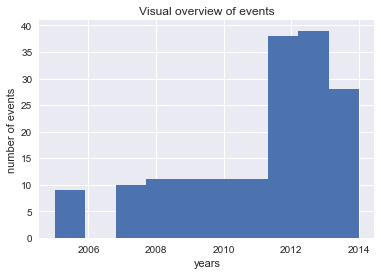

In [44]:
events = read_events("../data/events.csv")

# The dataset has the year, month, and day in three different cells. We would like to have this information in one cell
dates = []
for index, row in events.iterrows():
    date = str(events.iloc[index]['year']) + "-" + str(events.iloc[index]['month']) + "-" + str(events.iloc[index]['day'])
    dates.append(date)

# CREATE A NEW DATA FRAME AND MERGE WITH EVENT DATA FRAME
df2 = pd.DataFrame(dates, columns=['date'])
events = pd.concat([events, df2], axis=1)
events['date'] = pd.to_datetime(events['date'], format='%Y-%m-%d')

# Drop duplicates
events.drop_duplicates(subset=['description', 'date'], keep='first', inplace=True)

# APPLY FILTER TO EVENT DATA FRAME
events_filtered = events[(events['year'] < 2015)]

print('')
print('---------------------------------------------------------')
print('')

print('Preview of the dataset')
print('')

print(events_filtered.head())

print('')
print('---------------------------------------------------------')
print('')

print('Total number of events: %s' % len(list(events_filtered.description)))

print('')
print('---------------------------------------------------------')
print('')

print('Visual overview of events')
print('')

plt.hist(list(events_filtered.year))

plt.title('Visual overview of events')
plt.xlabel('years')
plt.ylabel('number of events')

### 2. Load the Listening data

We load a dataframe that contains the absolute playcount per genre for each country on a daily basis. This data is obtained from the - itemLE_10000_userLE_1000 -  files as created by Markus.

In [35]:
df = pd.DataFrame(json.load(open("../data/allCountries_relativePlaycount_Genre.json")))
df['week'] = pd.to_datetime(df['week'], format='%Y-%m-%d')
df.set_index('week', inplace=True)
del df['relative_play']

# FILTER COUNTRIES
df_filter = df[(df.country == COUNTRY_OF_INTEREST) & (df.genre == "total_playcount")]

print('')
print('---------------------------------------------------------')
print('')

print('Filter: %s' % COUNTRY_OF_INTEREST)

print('')
print('---------------------------------------------------------')
print('')

print('Preview of the dataset')
print('')
print(df_filter.head())

print('')
print('---------------------------------------------------------')
print('')


---------------------------------------------------------

Filter: US

---------------------------------------------------------

Preview of the dataset

           country            genre  playcount  relative_play  year
week                                                               
2005-01-01      US  total_playcount        856            1.0  2005
2005-02-14      US  total_playcount        508            1.0  2005
2005-02-15      US  total_playcount        634            1.0  2005
2005-02-16      US  total_playcount        635            1.0  2005
2005-02-17      US  total_playcount        637            1.0  2005

---------------------------------------------------------



After performing our first analysis, we hypothesized that the daily absolute number of playcounts is influenced by the number of active users that day. Therefore, we created a dataset that includes the number of unqiue users per day. 

Comment of Markus on number of listeners: "lower number of LEs/users are caused by the applied sampling strategy (capped at the latest 20k LEs for most users) - when using the user.getRecentTracks API endpoint. therefore, for frequent users, these 20k LEs just don't date back until the early years)."

In [6]:
unqiue_listeners_per_day = pd.DataFrame(json.load(open("../data/unique_users_per_day.json")))
unqiue_listeners_per_day['date'] = pd.to_datetime(unqiue_listeners_per_day['date'], format='%Y-%m-%d')
unqiue_listeners_per_day.set_index('date', inplace=True)
unqiue_listeners_per_day.sort_index(inplace=True)

print('')
print('---------------------------------------------------------')
print('')

print('Preview of the dataset')
print('')
print(unqiue_listeners_per_day.head())

print('')
print('---------------------------------------------------------')
print('')

print('Number of days for which we have unique listeners: %s' % len(list(unqiue_listeners_per_day['number_of_unqiue_listeners'])))

print('')
print('---------------------------------------------------------')
print('')




---------------------------------------------------------

Preview of the dataset

            number_of_unqiue_listeners
date                                  
1970-01-01                           2
2005-02-14                          73
2005-02-15                          77
2005-02-16                          75
2005-02-17                          68

---------------------------------------------------------

Number of days for which we have unique listeners: 3493

---------------------------------------------------------



We concatinate both the event and unqiue user dataframe, and add a new column that devides the playcount through the number of unqiue users. We do this eliminate an effect possible caused by the number of users that listen.

In [7]:
DF = pd.concat([df_filter, unqiue_listeners_per_day], axis=1, join='inner')
DF['rel_play'] = DF['playcount'] / DF['number_of_unqiue_listeners']
print(DF.head())

           country            genre  playcount  relative_play  year  \
2005-02-14      US  total_playcount        508            1.0  2005   
2005-02-15      US  total_playcount        634            1.0  2005   
2005-02-16      US  total_playcount        635            1.0  2005   
2005-02-17      US  total_playcount        637            1.0  2005   
2005-02-18      US  total_playcount        435            1.0  2005   

            number_of_unqiue_listeners  rel_play  
2005-02-14                          73  6.958904  
2005-02-15                          77  8.233766  
2005-02-16                          75  8.466667  
2005-02-17                          68  9.367647  
2005-02-18                          73  5.958904  


### 3. Statistical tests

#### 3.1 T-test on original signal

We perform a two-sample Welsh t-test, which assumes unequal variance, on the number of songs played per user on a daily basis. The first sample is the absolute playcount of songs N days prior to the event, the second sample comprises the absolute playcount 7 days after the event (including the event date itself. We have set the required significance level at .05.
We let the script print the event if there is a significant difference between the both. Furthermore, we create a plot for each significant event. 

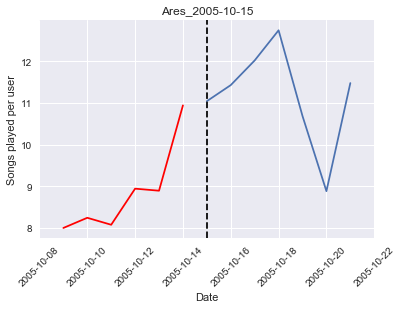

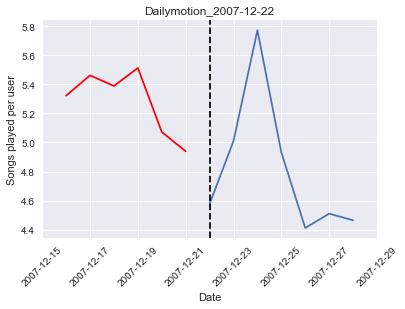

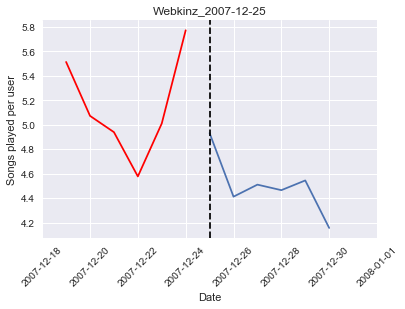

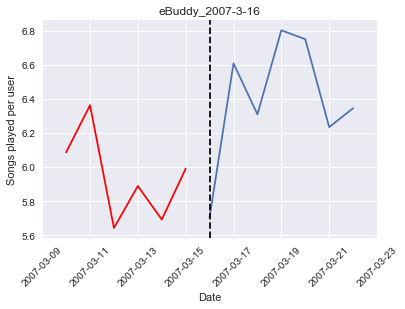

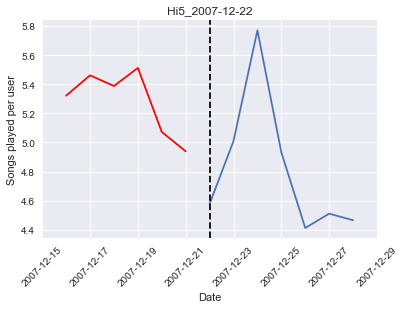

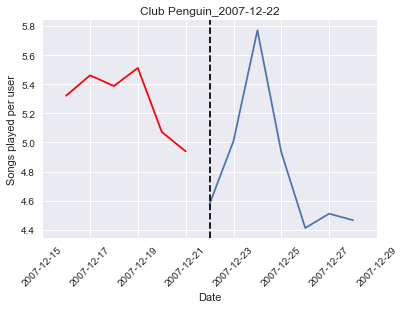

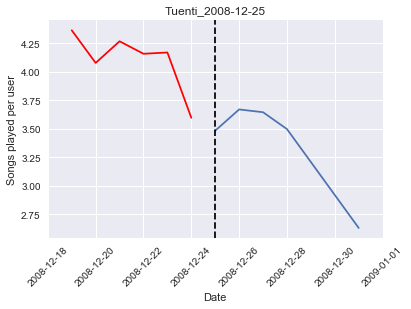

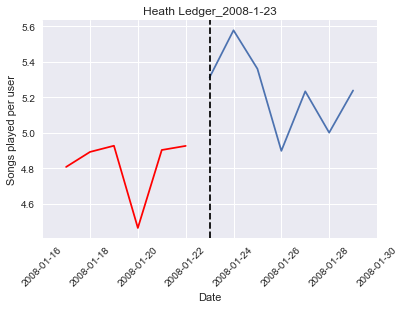

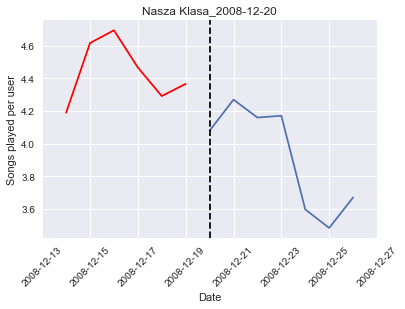

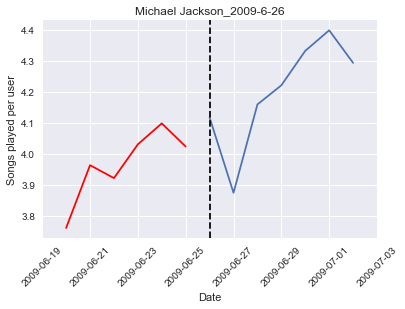

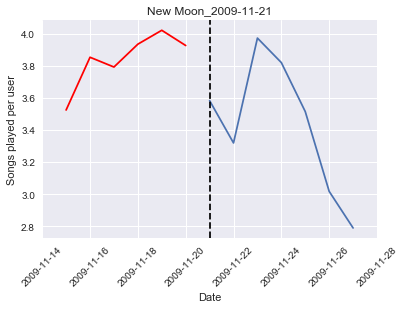

/Users/eelcowiechert/anacona36/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3126: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/eelcowiechert/anacona36/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


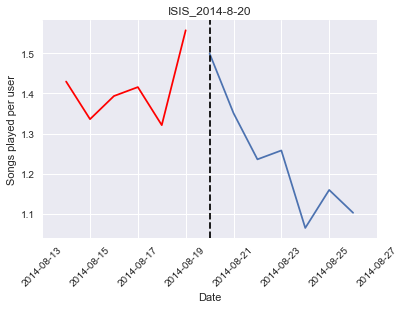

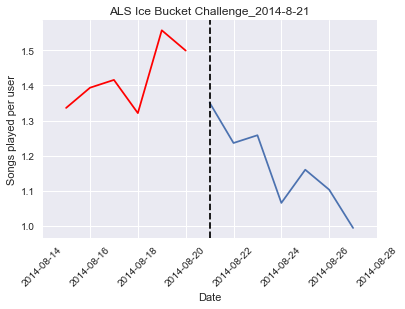

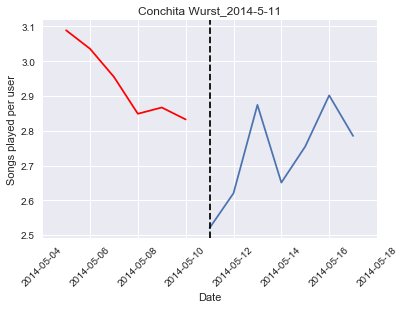


---------------------------------------------------------

Preview of the dataset

  date_event         name  statistic   p-value
0 2005-10-15         Ares  -3.630748  0.003984
1 2007-12-22  Dailymotion   2.300159  0.047582
2 2007-12-25      Webkinz   3.178497  0.012866
3 2007-03-16       eBuddy  -2.513526  0.029359
4 2007-12-22          Hi5   2.300159  0.047582

---------------------------------------------------------

Number of events for which we found a significant effect: 14

---------------------------------------------------------



In [61]:
# where we would like to save the significant events
temp_store = []

for year in list(set(df_filter['year'])):
    
    #df_focus = df_filter[(df_filter.year == year)]
    df_focus = DF[(DF.year == year)]

    #df_filter_years_genres = df_filter_years[(df_filter.genre == genre)]

    for index, row in events_filtered.iterrows():
        dateEvent = row.date
        dateBefore = row.date - timedelta(days=N)
        dateAfter = row.date + timedelta(days=N)

        # ONLY FOR X DAYS BEFORE AND AFTER THE EVENT
        group_A = df_focus.loc[(df_focus.index < dateEvent) & (df_focus.index > dateBefore)]
        group_B = df_focus.loc[(df_focus.index >= dateEvent) & (df_focus.index < dateAfter)]

        list_1 = list(group_A['rel_play'])
        list_2 = list(group_B['rel_play'])

        t_test = scipy.stats.ttest_ind(list_1, list_2, equal_var=False)

        # PRINT EVENT WHEN SIGNIFICANT
        if t_test[1] < 0.05:
            # create a new dataframe an add this to the dataframe that stores all events
            temp_dataframe = [row.date, row.description, t_test[0], t_test[1]]
            temp_store.append(temp_dataframe)
            
            # create a plot and store it in the data/figure folder
            plt.plot(group_A.index, group_A.rel_play, color='r')
            plt.plot(group_B.index, group_B.rel_play)
            plt.axvline(x=row.date, color="black", linestyle="--")
            plt.xlim([dateBefore, dateAfter])
            plt.xticks(rotation=45)
            plt.xlabel('Date')
            plt.ylabel('Songs played per user')
            plt.title(str(row.description) + '_' + str(row.year) + '-'+ str(row.month) + '-'+ str(row.day))
            #plt.savefig('../data/figures/' + str(row.description) + '_' + str(row.year) + '-'+ str(row.month) + '-'+ str(row.day) + '.png', dpi=300)
            #plt.close()
            plt.show()

events_t_test = pd.DataFrame(temp_store, columns=['date_event', 'name', 'statistic', 'p-value'])

print('')
print('---------------------------------------------------------')
print('')

print('Preview of the dataset')
print('')
print(events_t_test.head())

print('')
print('---------------------------------------------------------')
print('')

print('Number of events for which we found a significant effect: %s' % len(events_t_test['date_event']))

print('')
print('---------------------------------------------------------')
print('')

##### 3.1.1 Preliminary conslusion

We find a significant difference between both samples for 14 cases. 

Visual inspecting the plots shows that the following events might be have an influence on the number of songs played:

- Dailymotion

- Webkinz

- eBuddy

- Hi 5 and/or Club Penguin (same day)

- Heath Ledger

- Michael Jackson

- New Moon

The above events show a significant change, starting from the day of the event.

A visual inspection of the plots shows that the seasonal component might have a significant influence on a the results. It might make sense to remove this component from the data. 

### 3.2 Remove effects caused by seasonal data

As we seems that the data is influenced by a seasonal component (re-occuring pattern), we create a new dataframe which includes a seperation of the original dataframe into a trend, seasonal and residual component.

In [38]:
# Load the data that contains the trend, seasonal, and residual component
df = pd.DataFrame(json.load(open("../data/TSA_one_genre_components.json")))

# Convert columns to correct dtypes
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['original'] = df['original'].astype('float64')
df['trend'] = df['trend'].astype('float64')
df['seasonal'] = df['seasonal'].astype('float64')
df['residual'] = df['residual'].astype('float64')

# CREATE DATA WITHOUT SEASONAL COMPONENT
df['no_seas'] = df['original'] - df['seasonal']

# FILTER COUNTRIES
df_filter = df[(df.country == COUNTRY_OF_INTEREST)]

df_filter['year'] = df_filter['date'].map(get_year)
df_filter.set_index('date', inplace=True)
print(df_filter.head())

           country            genre  original  residual   seasonal  trend  \
date                                                                        
2005-01-01      US  total_playcount     856.0       NaN -34.666493    NaN   
2005-02-14      US  total_playcount     508.0       NaN  37.839847    NaN   
2005-02-15      US  total_playcount     634.0       NaN -19.994159    NaN   
2005-02-16      US  total_playcount     635.0       NaN -88.823265    NaN   
2005-02-17      US  total_playcount     637.0       NaN -11.010729    NaN   

               no_seas  year  
date                          
2005-01-01  890.666493  2005  
2005-02-14  470.160153  2005  
2005-02-15  653.994159  2005  
2005-02-16  723.823265  2005  
2005-02-17  648.010729  2005  


/Users/eelcowiechert/anacona36/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [62]:
DF = pd.concat([df_filter, unqiue_listeners_per_day], axis=1, join='inner')
DF['rel_no_seas'] = DF['no_seas'] / DF['number_of_unqiue_listeners']
DF['rel_trend'] = DF['trend'] / DF['number_of_unqiue_listeners']
print(DF.head())

           country            genre  original  residual   seasonal  trend  \
date                                                                        
2005-02-14      US  total_playcount     508.0       NaN  37.839847    NaN   
2005-02-15      US  total_playcount     634.0       NaN -19.994159    NaN   
2005-02-16      US  total_playcount     635.0       NaN -88.823265    NaN   
2005-02-17      US  total_playcount     637.0       NaN -11.010729    NaN   
2005-02-18      US  total_playcount     435.0 -3.557515 -96.242485  534.8   

               no_seas  year  number_of_unqiue_listeners  rel_no_seas  \
date                                                                    
2005-02-14  470.160153  2005                          73     6.440550   
2005-02-15  653.994159  2005                          77     8.493431   
2005-02-16  723.823265  2005                          75     9.650977   
2005-02-17  648.010729  2005                          68     9.529570   
2005-02-18  531.242485

Again, we perform a Welsh t-test

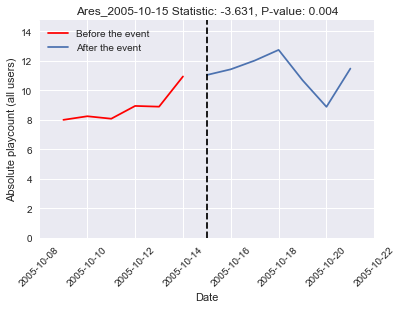

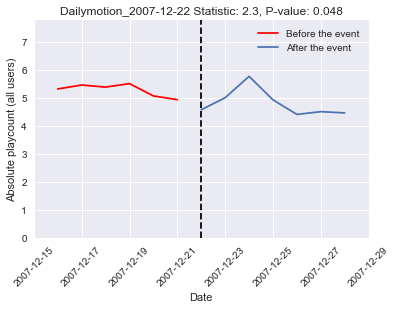

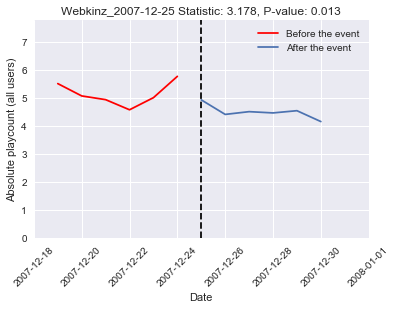

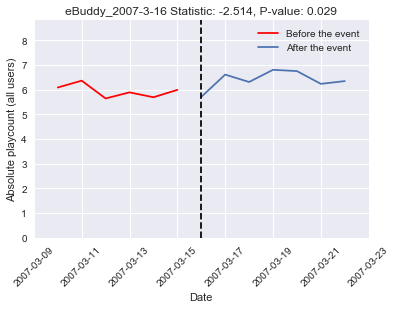

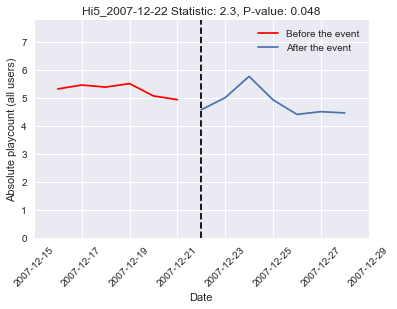

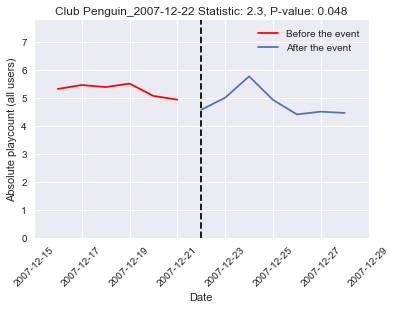

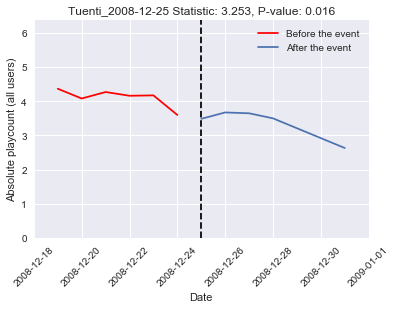

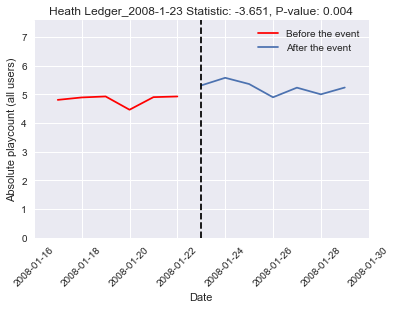

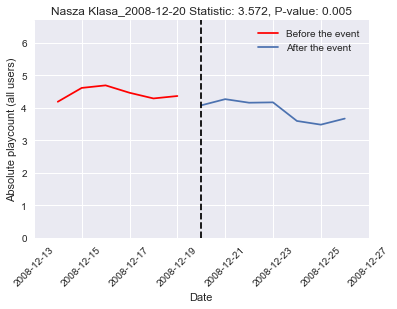

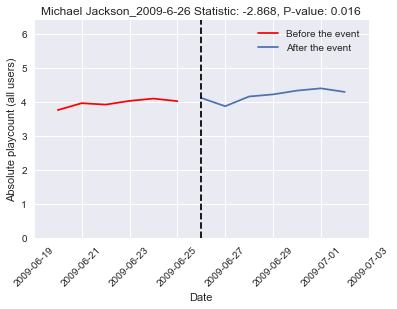

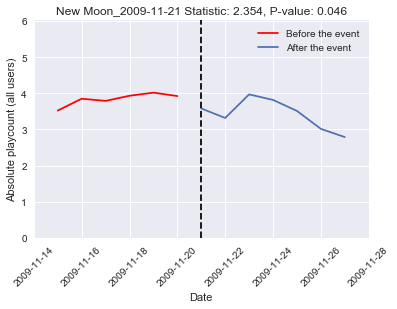

/Users/eelcowiechert/anacona36/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3126: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/eelcowiechert/anacona36/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


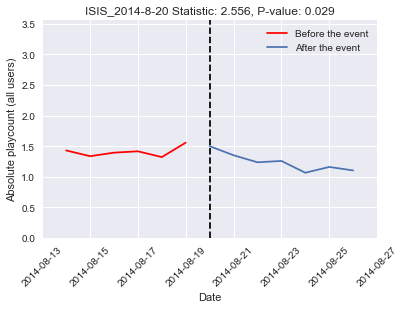

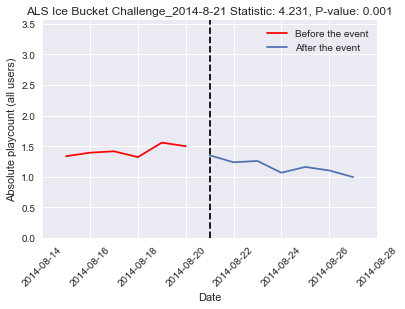

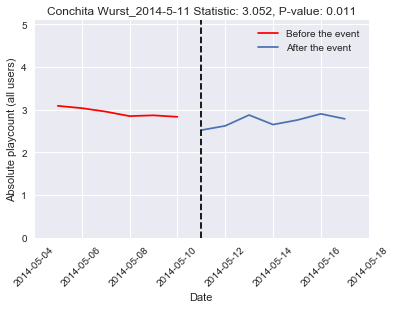


---------------------------------------------------------

Preview of the dataset

  date_event         name  statistic   p-value
0 2005-10-15         Ares  -3.630748  0.003984
1 2007-12-22  Dailymotion   2.300159  0.047582
2 2007-12-25      Webkinz   3.178497  0.012866
3 2007-03-16       eBuddy  -2.513526  0.029359
4 2007-12-22          Hi5   2.300159  0.047582

---------------------------------------------------------

Number of events for which we found a significant effect: 14

---------------------------------------------------------



In [70]:
# where we would like to save the significant events
temp_store = []

for year in list(set(df_filter['year'])):
    
    #df_focus = df_filter[(df_filter.year == year)]
    df_focus = DF[(DF.year == year)]

    #df_filter_years_genres = df_filter_years[(df_filter.genre == genre)]

    for index, row in events_filtered.iterrows():
        dateEvent = row.date
        dateBefore = row.date - timedelta(days=N)
        dateAfter = row.date + timedelta(days=N)

        # ONLY FOR X DAYS BEFORE AND AFTER THE EVENT
        group_A = df_focus.loc[(df_focus.index < dateEvent) & (df_focus.index > dateBefore)]
        group_B = df_focus.loc[(df_focus.index >= dateEvent) & (df_focus.index < dateAfter)]
        list_1 = list(group_A['rel_no_seas'])
        list_2 = list(group_B['rel_no_seas'])

        t_test = scipy.stats.ttest_ind(list_1, list_2, equal_var=False)
        
        # PRINT EVENT WHEN SIGNIFICANT
        if t_test[1] < 0.05:
            # create a new dataframe an add this to the dataframe that stores all events
            temp_dataframe = [row.date, row.description, t_test[0], t_test[1]]
            temp_store.append(temp_dataframe)
            
            # create a plot and store it in the data/figure folder
            plt.plot(group_A.index, group_A.rel_no_seas, color='r', label='Before the event')
            plt.plot(group_B.index, group_B.rel_no_seas, label='After the event')
            plt.legend()
            plt.axvline(x=row.date, color="black", linestyle="--")
            plt.xlim([dateBefore, dateAfter])
            plt.ylim([0,max(max(list_1),max(list_2))+2])
            plt.xticks(rotation=45)
            plt.xlabel('Date')
            plt.ylabel('Absolute playcount (all users)')
            plt.title(str(row.description) + '_' + str(row.year) + '-'+ str(row.month) + '-'+ str(row.day) + ' Statistic: %s, P-value: %s' % (str(round(t_test[0], 3)), str(round(t_test[1], 3))))
            #plt.savefig('../data/figures/No_seasonal_' + str(row.description) + '_' + str(row.year) + '-'+ str(row.month) + '-'+ str(row.day) + '.png', dpi=300)
            #plt.close()
            plt.show()

events_t_test_no_seasonal = pd.DataFrame(temp_store, columns=['date_event', 'name', 'statistic', 'p-value'])

print('')
print('---------------------------------------------------------')
print('')

print('Preview of the dataset')
print('')
print(events_t_test_no_seasonal.head())

print('')
print('---------------------------------------------------------')
print('')

print('Number of events for which we found a significant effect: %s' % len(events_t_test_no_seasonal['date_event']))

print('')
print('---------------------------------------------------------')
print('')

##### 3.2.1 Preliminary conslusion

We find a significant difference between both samples for 14 cases. 

Visual inspecting the plots shows that the following events might be have an influence on the number of songs played:

- Dailymotion

- Hi 5 and/or Club Penguin (same day)

- Heath Ledger

- New Moon

The above events show a significant change, starting from the day of the event. All these events are also indicated in the first analysis

A continous line that connects all data points is visable in most of the plots. This indicates that a found difference of the group mean is mainly cause by a wider upward or downward trend. Tuenti-2008 is a nice example of this.

### 4. Compare methods

We compare both methods

#### Show differences between two dataframes 

We are interested in the difference between the two dataframes (i.e., with the seasonal component, and without). From the dataframe below, we can see that the dataframe that includes the seasonal component finds a significant difference for Michael Jackson and New Moon, while this is not found when the seasonal component is removed. In contrast, for Sky News (London Bombing), Facebook, YouTube and Samsung Note 4, there is a significant difference found, that was not there when the seasonal component was included.

In [55]:
difference = pd.concat([events_t_test, events_t_test_no_seasonal])
difference.drop_duplicates(subset=['name', 'date_event'], keep=False, inplace=True)
print(difference)

   date_event             name  statistic   p-value
9  2009-06-26  Michael Jackson  -2.868153  0.015936
10 2009-11-21         New Moon   2.353709  0.045581
1  2005-07-07         Sky News  -2.918285  0.014400
2  2007-12-24         Facebook   3.070916  0.011749
5  2007-12-23          YouTube   3.390345  0.006858
12 2014-08-31   Samsung Note 4   3.414536  0.040511


### Remarks

- When we calculate the seasonal component, we consider the whole dataset. This dataset is influenced by the number of people that listen music, which is also influenced by the year given that only the last 10k listening events are captured. These fluctuations might cause real seasonal patterns to vanish. It might make more sense to only consider one year, or one month to calculate the seasonality component instead of the whole dataset.